# Estrategia de Cobertura del SPY con Opciones PUT

## Objetivo
Este notebook implementa y analiza una estrategia de inversión que combina:
- **Inversión principal**: 100% del capital en SPY (ETF del S&P 500)
- **Cobertura**: Compra de opciones PUT mensuales 10% OTM (Out of The Money)

## Hipótesis
Las opciones PUT protegen contra caídas significativas del mercado (>10%), reduciendo la volatilidad y el drawdown máximo del portafolio, a cambio de un coste recurrente (prima de las opciones).

## Estrategia
- **Strike de la PUT**: 10% por debajo del precio actual del SPY
- **Vencimiento**: 30 días (renovación al vencimiento)
- **Valoración**: Modelo Black-Scholes con ajustes conservadores
- **Cobertura**: 100% del capital invertido

## 1. Configuración e Importación de Librerías

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [2]:
# Parámetros de la estrategia
INITIAL_CAPITAL = 100000  # Capital inicial
OTM_PERCENT = 0.10  # Strike 10% por debajo del precio actual
DAYS_TO_EXPIRY = 90  # TRIMESTRAL  # Vencimiento de las PUT en días
VOLATILITY_SKEW_ADJUSTMENT = 1.20  # Ajuste conservador: +20% a la volatilidad
TRANSACTION_COST_PCT = 0.001  # 0.1% por operación de opciones
VOLATILITY_WINDOW = 30  # Ventana para calcular volatilidad histórica

# Fechas del backtest
START_DATE = "2001-11-01"  # Máximo histórico con datos de ^IRX
# 2002-01 a 2025
END_DATE = datetime.now().strftime("%Y-%m-%d")

print(f"Parámetros de la estrategia:")
print(f"  - Capital inicial: ${INITIAL_CAPITAL:,.0f}")
print(f"  - Strike PUT: {OTM_PERCENT*100:.0f}% OTM")
print(f"  - Vencimiento: {DAYS_TO_EXPIRY} días")
print(f"  - Ajuste volatilidad: +{(VOLATILITY_SKEW_ADJUSTMENT-1)*100:.0f}%")
print(f"  - Costes transacción: {TRANSACTION_COST_PCT*100:.1f}%")
print(f"  - Período: {START_DATE} a {END_DATE} (~24 años de datos)")


Parámetros de la estrategia:
  - Capital inicial: $100,000
  - Strike PUT: 10% OTM
  - Vencimiento: 90 días
  - Ajuste volatilidad: +20%
  - Costes transacción: 0.1%
  - Período: 2001-11-01 a 2025-10-31 (~24 años de datos)


## 2. Descarga de Datos Históricos del SPY

In [3]:
# Descargar datos de SPY
print(f"Descargando datos de SPY desde {START_DATE} hasta {END_DATE}...")
spy = yf.Ticker("SPY")
spy_data = spy.history(start=START_DATE, end=END_DATE)

# Limpiar datos
spy_data = spy_data[['Close']].copy()
spy_data.columns = ['price']
spy_data = spy_data.dropna()

# Calcular retornos diarios
spy_data['returns'] = spy_data['price'].pct_change()

# Calcular volatilidad histórica (anualizada, ventana móvil)
spy_data['volatility'] = spy_data['returns'].rolling(window=VOLATILITY_WINDOW).std() * np.sqrt(252)

# Eliminar NaN iniciales
spy_data = spy_data.dropna()

print(f"\n✓ Datos descargados: {len(spy_data)} días de trading")
print(f"  Rango: {spy_data.index[0].strftime('%Y-%m-%d')} a {spy_data.index[-1].strftime('%Y-%m-%d')}")
print(f"\nEstadísticas del SPY:")
print(f"  Precio promedio: ${spy_data['price'].mean():.2f}")
print(f"  Volatilidad promedio: {spy_data['volatility'].mean()*100:.2f}%")
print(f"  Retorno total: {((spy_data['price'].iloc[-1] / spy_data['price'].iloc[0]) - 1) * 100:.2f}%")

spy_data.head()

Descargando datos de SPY desde 2001-11-01 hasta 2025-10-31...



✓ Datos descargados: 6008 días de trading
  Rango: 2001-12-14 a 2025-10-30

Estadísticas del SPY:
  Precio promedio: $202.93
  Volatilidad promedio: 16.09%
  Retorno total: 832.55%


,price,returns,volatility
Date,,,
2001-12-14 00:00:00-05:00,72.9005,0.0095,0.1759
2001-12-17 00:00:00-05:00,73.6544,0.0103,0.1771
2001-12-18 00:00:00-05:00,74.0926,0.0059,0.1742
2001-12-19 00:00:00-05:00,74.6146,0.0070,0.1699
2001-12-20 00:00:00-05:00,73.8799,-0.0098,0.1727


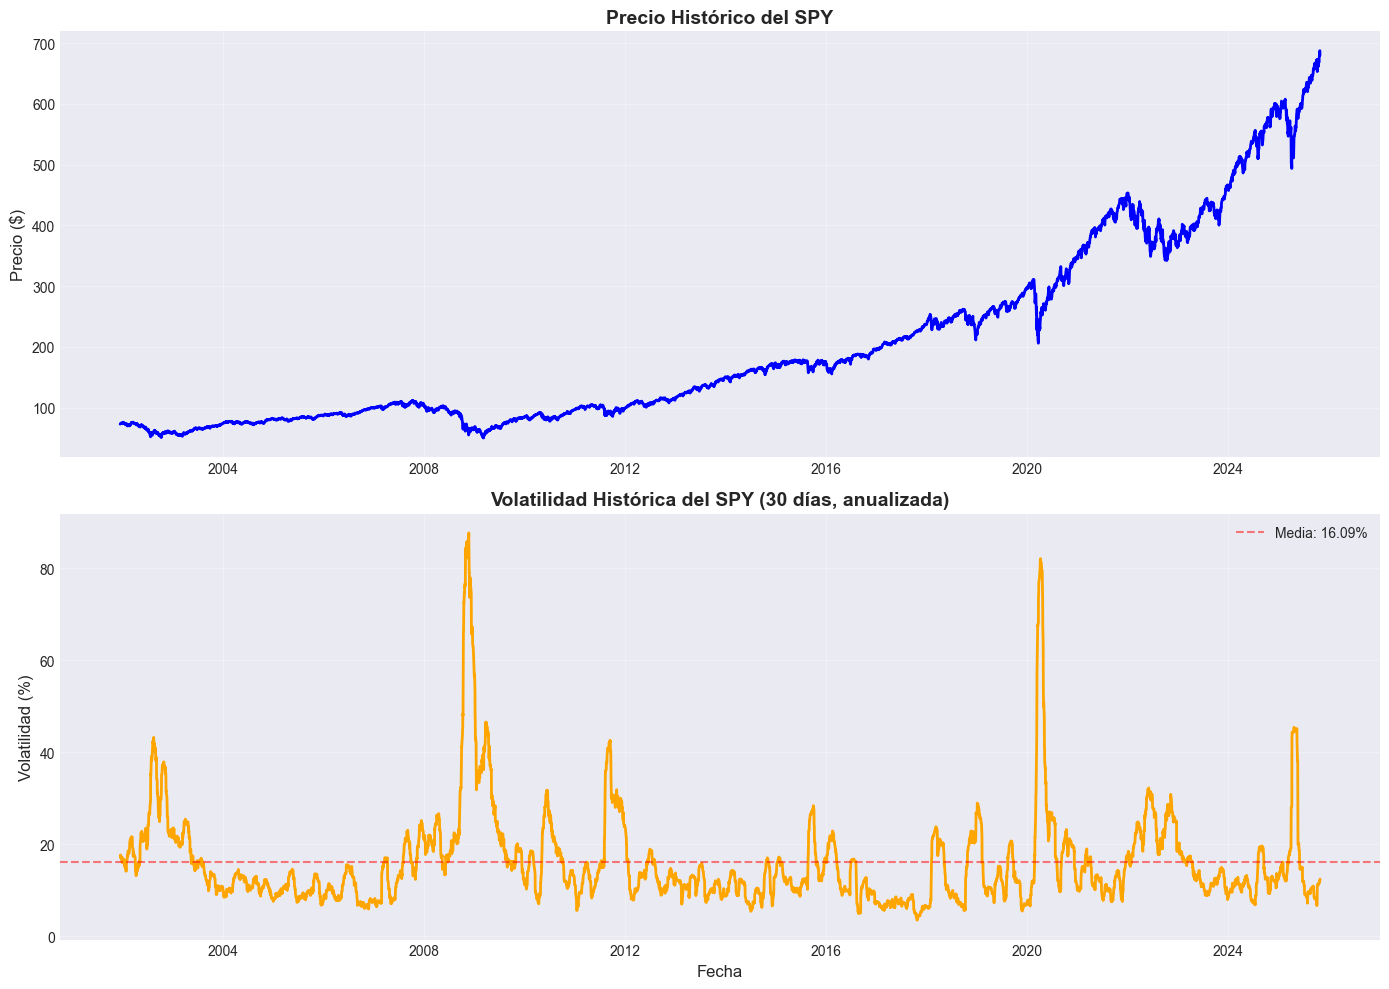

In [4]:
# Visualizar precio y volatilidad del SPY
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Precio
axes[0].plot(spy_data.index, spy_data['price'], linewidth=2, color='blue')
axes[0].set_title('Precio Histórico del SPY', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precio ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Volatilidad
axes[1].plot(spy_data.index, spy_data['volatility'] * 100, linewidth=2, color='orange')
axes[1].axhline(y=spy_data['volatility'].mean() * 100, color='red', linestyle='--', alpha=0.5, 
                label=f'Media: {spy_data["volatility"].mean()*100:.2f}%')
axes[1].set_title('Volatilidad Histórica del SPY (30 días, anualizada)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatilidad (%)', fontsize=12)
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Descarga de Tasa Libre de Riesgo (Treasury Bill 3 meses)

In [5]:
# Descargar tasa libre de riesgo (Treasury Bill 3 meses)
print("Descargando tasa libre de riesgo (^IRX - Treasury Bill 3M)...")
try:
    irx = yf.Ticker("^IRX")
    irx_data = irx.history(start=START_DATE, end=END_DATE)
    
    # Usar precio de cierre y convertir a tasa decimal
    risk_free_rate = irx_data[['Close']].copy()
    risk_free_rate.columns = ['rate']
    risk_free_rate['rate'] = risk_free_rate['rate'] / 100  # Convertir de % a decimal
    
    # Forward fill para llenar días sin datos (fines de semana, festivos)
    risk_free_rate = risk_free_rate.reindex(spy_data.index, method='ffill')
    
    # Si hay NaN al inicio, backfill
    risk_free_rate = risk_free_rate.fillna(method='bfill')
    
    # Si aún hay NaN, usar valor por defecto (3%)
    risk_free_rate = risk_free_rate.fillna(0.03)
    
    print(f"✓ Tasa libre de riesgo descargada")
    print(f"  Tasa promedio: {risk_free_rate['rate'].mean()*100:.2f}%")
    print(f"  Tasa mínima: {risk_free_rate['rate'].min()*100:.2f}%")
    print(f"  Tasa máxima: {risk_free_rate['rate'].max()*100:.2f}%")
    
except Exception as e:
    print(f"⚠ Error descargando ^IRX: {e}")
    print("  Usando tasa fija del 3% como fallback")
    risk_free_rate = pd.DataFrame({'rate': 0.03}, index=spy_data.index)

# Combinar con datos de SPY
spy_data['risk_free_rate'] = risk_free_rate['rate']

Descargando tasa libre de riesgo (^IRX - Treasury Bill 3M)...


✓ Tasa libre de riesgo descargada
  Tasa promedio: 1.63%
  Tasa mínima: -0.10%
  Tasa máxima: 5.35%


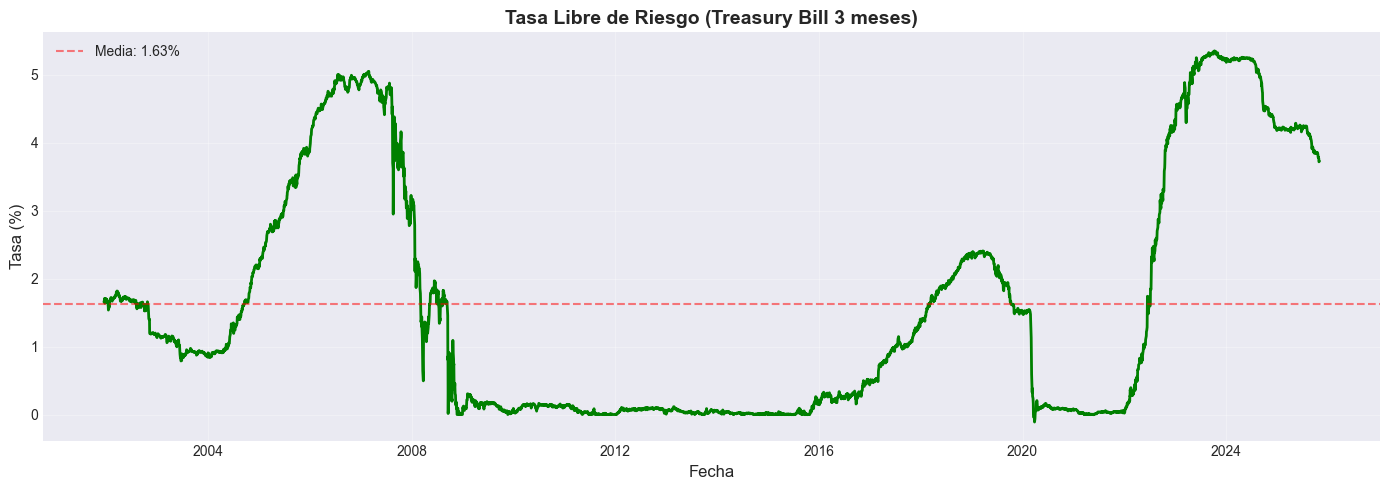

In [6]:
# Visualizar evolución de la tasa libre de riesgo
plt.figure(figsize=(14, 5))
plt.plot(spy_data.index, spy_data['risk_free_rate'] * 100, linewidth=2, color='green')
plt.axhline(y=spy_data['risk_free_rate'].mean() * 100, color='red', linestyle='--', alpha=0.5,
            label=f'Media: {spy_data["risk_free_rate"].mean()*100:.2f}%')
plt.title('Tasa Libre de Riesgo (Treasury Bill 3 meses)', fontsize=14, fontweight='bold')
plt.ylabel('Tasa (%)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Implementación del Modelo Black-Scholes para Opciones PUT

In [7]:
def black_scholes_put(S, K, T, r, sigma):
    """
    Calcula el precio teórico de una opción PUT europea usando Black-Scholes.
    
    Parámetros:
    -----------
    S : float
        Precio actual del subyacente
    K : float
        Precio de ejercicio (strike)
    T : float
        Tiempo hasta vencimiento en años
    r : float
        Tasa libre de riesgo anual (decimal)
    sigma : float
        Volatilidad anual (decimal)
    
    Retorna:
    --------
    float : Precio de la opción PUT
    """
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(K - S, 0)  # Valor intrínseco si hay parámetros inválidos
    
    # Calcular d1 y d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calcular precio de PUT usando Black-Scholes
    # PUT = K * e^(-rT) * N(-d2) - S * N(-d1)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return put_price


def calculate_put_value(S, K, T, r, sigma):
    """
    Calcula el valor actual de una PUT (antes del vencimiento usa Black-Scholes,
    al vencimiento usa valor intrínseco).
    """
    if T <= 0:
        # Al vencimiento: valor intrínseco
        return max(K - S, 0)
    else:
        # Antes del vencimiento: Black-Scholes
        return black_scholes_put(S, K, T, r, sigma)


# Prueba del modelo
print("Prueba del modelo Black-Scholes:")
print("="*50)
test_S = 400  # Precio SPY
test_K = 360  # Strike 10% OTM
test_T = 30/365  # 30 días
test_r = 0.04  # 4% anual
test_sigma = 0.18  # 18% volatilidad

test_price = black_scholes_put(test_S, test_K, test_T, test_r, test_sigma)
test_price_adjusted = black_scholes_put(test_S, test_K, test_T, test_r, test_sigma * VOLATILITY_SKEW_ADJUSTMENT)

print(f"Precio SPY: ${test_S}")
print(f"Strike PUT: ${test_K} ({((test_K/test_S - 1)*100):.1f}% OTM)")
print(f"Días hasta vencimiento: 30")
print(f"Tasa libre riesgo: {test_r*100:.1f}%")
print(f"Volatilidad: {test_sigma*100:.1f}%")
print(f"\nPrecio PUT (Black-Scholes estándar): ${test_price:.2f} ({test_price/test_S*100:.2f}% del precio)")
print(f"Precio PUT (ajustado +20% vol): ${test_price_adjusted:.2f} ({test_price_adjusted/test_S*100:.2f}% del precio)")
print(f"\n✓ Modelo Black-Scholes implementado correctamente")

Prueba del modelo Black-Scholes:
Precio SPY: $400
Strike PUT: $360 (-10.0% OTM)
Días hasta vencimiento: 30
Tasa libre riesgo: 4.0%
Volatilidad: 18.0%

Precio PUT (Black-Scholes estándar): $0.12 (0.03% del precio)
Precio PUT (ajustado +20% vol): $0.38 (0.09% del precio)

✓ Modelo Black-Scholes implementado correctamente
